In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [18]:
im_arena = cv2.imread('./arena_wide.jpeg')
im_arena = cv2.resize(im_arena, [2592, 1944])
im = cv2.cvtColor(im_arena,cv2.COLOR_BGR2GRAY)
im2 = cv2.imread('1.jpeg')
im2 = cv2.resize(im2, [2592, 1944])
im2 = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

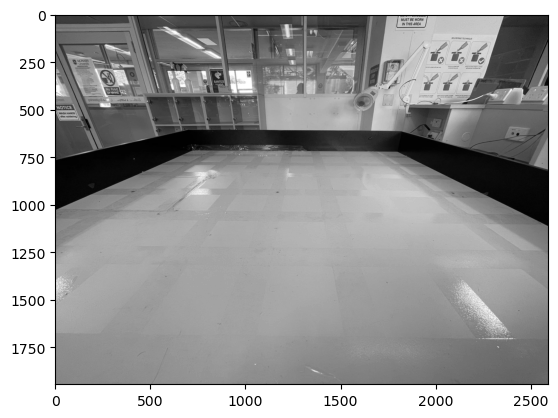

In [19]:
plt.imshow(im2,cmap = 'gray')
plt.show()

In [20]:
print(im2.shape[0])

1944


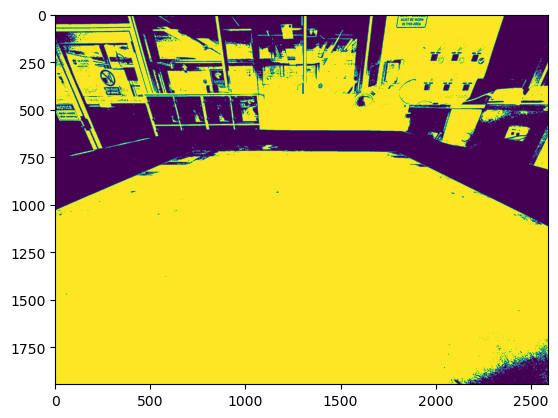

In [21]:
felt = (im2>105)
plt.imshow(felt)
plt.show()

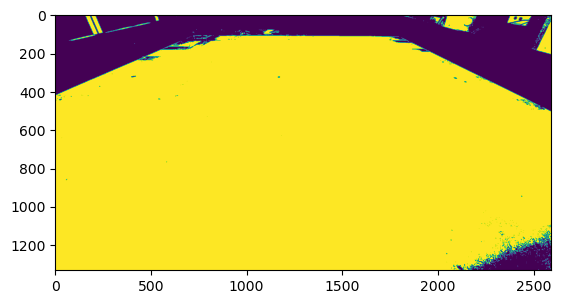

In [22]:
crop_line = float('nan')
for i in range(felt.shape[0]):
    for j in range(felt.shape[1] - 800):
        if (np.sum(felt[i,j:j+800]) == 0):
            crop_line = i
            break
    if ~np.isnan(crop_line):
        break
    
crop_image = felt[crop_line:,:]

plt.imshow(crop_image)
plt.show()

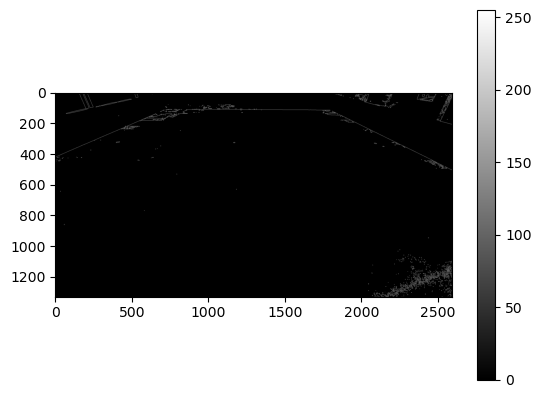

In [23]:
edges = cv2.Canny(crop_image.astype(np.uint8)*255,100,200)

plt.imshow(edges,cmap = 'gray')
plt.colorbar()
plt.show()

In [24]:
def ransac_line(image,N=1000,max_error=2, existing_line_threshold=5):
    
    good_lines = []
    consensus_list = []
    
    points_x,points_y = np.where(edges>0)
    points_homog = np.vstack([points_x,points_y,np.ones(len(points_x))]).T
    
    for j in range(N):

        bins = np.random.choice(len(points_x),2,replace=False)

        line = np.cross(points_homog[bins[0],:],points_homog[bins[1],:])
        
        line = line/np.sqrt(line[0]**2 + line[1]**2)
        
        line = line.reshape(1,3)

        consensus = np.sum((np.abs(np.sum(line*points_homog,axis=-1)) <= max_error))
        
        if len(good_lines) > 0:


            # Check if line already found by comparing intercepts
            c_good = -np.vstack(good_lines)[:,2]/(np.vstack(good_lines)[:,0]+1e-19)
            c_line = -line[0,2]/(line[0,0]+1e-19)  

            d = np.abs(c_good-c_line)
            best_d = np.argmin(d)

            # Check if line alread exists 
            if (np.min(d) < existing_line_threshold):
                #if better than current consensus, replace line
                if (np.sum(d<existing_line_threshold)==1)&(consensus > consensus_list[best_d]): # existing line
                    good_lines[best_d] = line
                    consensus_list[best_d] = consensus
                    
            else:
                # less than 4 lines - add a new one
                if len(good_lines) < 3:
                    good_lines.append(line)
                    consensus_list.append(consensus)    
                # more than four lines, replace if better than worst line consensus
                elif (consensus > np.min(np.array(consensus_list))):
                    worst_consensus = np.argmin(np.array(consensus_list))
                    good_lines[worst_consensus] = line
                    consensus_list[worst_consensus] = consensus
            
        else:
            good_lines.append(line)
            consensus_list.append(consensus)

        # Some plotting
        if (j %100==0):
            plt.clf()
            plt.title(consensus_list)
            plt.imshow(edges,cmap = 'gray')
            x = np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int)
            for l in good_lines:
                l = l.ravel()
                #ax + by + c = 0 y = -ax/b -c/b
                m = -l[0]/(l[1]+1e-19)
                c = -l[2]/(l[1]+1e-19)    
                
                plt.plot(m*x + c,x)
            m = -line[0,0]/(line[0,1]+1e-19)
            c = -line[0,2]/(line[0,1]+1e-19)    
            plt.plot(m*x + c,x)

            plt.xlim(0,edges.shape[1])
            plt.ylim(edges.shape[0],0)
            # display.clear_output(wait=True)
            # display.display(plt.gcf())

        

    return good_lines, consensus_list

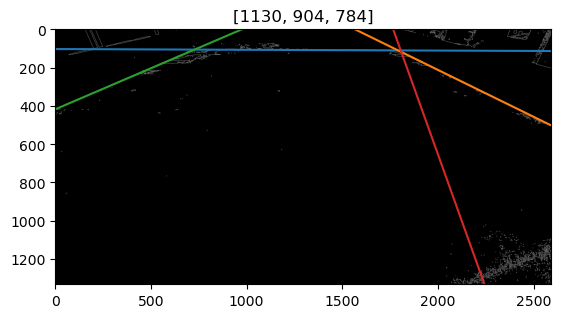

In [25]:
plt.imshow(edges,cmap = 'gray')

lines,consensus_list = ransac_line(edges,N=5000,max_error=2,existing_line_threshold=100)

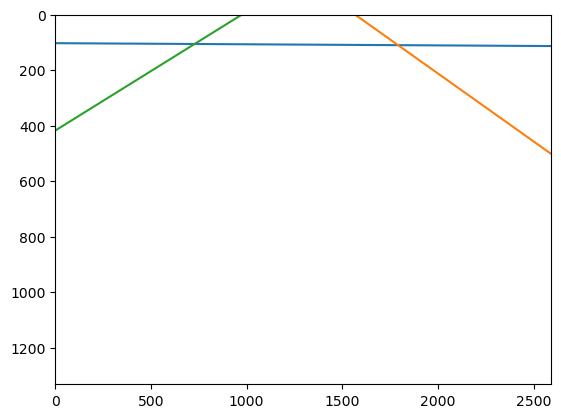

In [26]:
x = np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int)
for l in lines:
    l = l.ravel()
    #ax + by + c = 0 y = -ax/b -c/b
    m = -l[0]/(l[1]+1e-19)
    c = -l[2]/(l[1]+1e-19)    
    plt.plot(m*x + c,x)

plt.xlim(0,edges.shape[1])
plt.ylim(edges.shape[0],0)
plt.show()

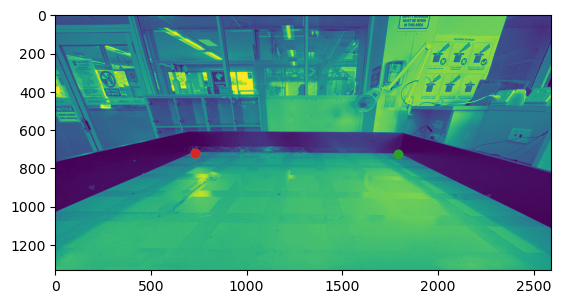

In [34]:
intercepts = []
plt.imshow(im2)
for l1 in lines:
    for l2 in lines:
        
        point = np.cross(l1,l2)
        point = point/(point[0,2]+1e-19)
        if (point[0,0]>0)&(point[0,1]>0)&(point[0,0]<edges.shape[0])&(point[0,1]<edges.shape[1]):
            intercepts.append(point)
            plt.plot(point[0,1],point[0,0]+crop_line,'o')
        
plt.xlim(0,edges.shape[1])
plt.ylim(edges.shape[0],0)
plt.show()

intercepts = np.unique(np.vstack((intercepts)),axis=0)
intercepts = intercepts[np.argsort(intercepts[:,0]),:]
intercepts = np.int0(intercepts[:,:-1])
intercepts[0,0] = intercepts[0,0]+crop_line
intercepts[1,0] = intercepts[1,0]+crop_line

In [30]:
print(point)

[[0. 0. 0.]]


In [16]:
print(intercepts)

[[ 718  725]
 [ 721 1793]]
